# Logistic regression - a simple classification algorithm

## Information collection
* Blog post explaining logreg from scratch in short: https://beckernick.github.io/logistic-regression-from-scratch/
* Github repo jupyter-notebook logreg from scratch: https://github.com/beckernick/logistic_regression_from_scratch/blob/master/logistic_regression_scratch.ipynb
* ayoai intro mashine learning and logreg: https://ayearofai.com/rohan-1-when-would-i-even-use-a-quadratic-equation-in-the-real-world-13f379edab3b#.986r1m90h
* ayoai deep dive in logreg: https://ayearofai.com/rohan-6-follow-up-statistical-interpretation-of-logistic-regression-e78de3b4d938

The logistic regression can be considered to be a **single perceptron**.

## follow Nick Beckers (NVIDIA) LogReg from scratch

In [1]:
# load the standard tools

#import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline

# this is equivalent to the above lines
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


### The data matters

To understand why this is useful, we can assume the data to be of some importance. In ML very frequently the classification of a tumor to be dangerous or not is used as an example. In our simple case, the two feature values (x,y) may be two measured parameters of a tumor and the labels $[0,1]$ might be dangerous and not dangerous.

In [29]:
# create data sets using random data -> data sets for different classes should be distinguishable

# fix the seed for reproduction
np.random.seed(12)

# define the number of points that belong to a single set
num_observations = 5000
#num_observations = 50

# fist set is the data of class "1 - true" normally distributed around (0,0) ...
x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
# ##  numpy.random.multivariate_normal(mean, cov[, size, check_valid, tol])
# ## mean : 1-D array_like, of length N: Mean of the N-dimensional distribution.
# ## cov : 2-D array_like, of shape (N, N): Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.

# ... that cane be distinguished from the data in second set belonging to class "0 -false"
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

In [30]:
# merge the data in compact numpy arrays

# stack the data in 'points -> class' arrays
# simulated_separableish_features[i] --has label--> simulated_labels[i]
simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

<IPython.core.display.Javascript object>


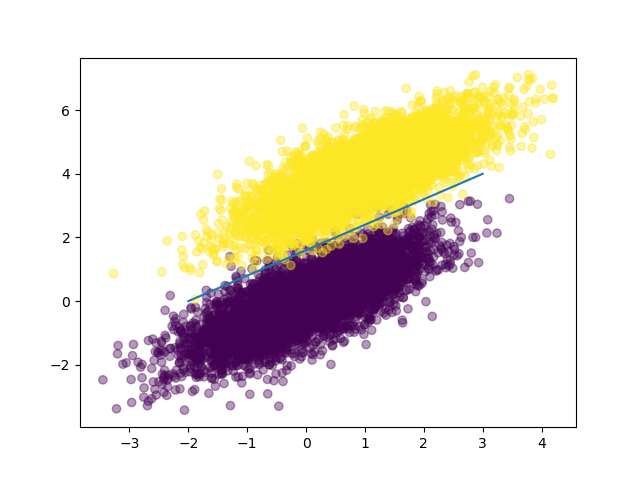

In [31]:
# plot the data and check if it is separable
figure()

scatter(simulated_separableish_features[:, 0],# x values of all points
        simulated_separableish_features[:, 1],# y values of all points
        c = simulated_labels,# colors map using the classes [1,0]
        alpha = .4 #transparancy in case theres are overlapping points
       )
# ## matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
# ## x, y : array_like, shape (n, ): The data positions.
# ## c : color, sequence, or sequence of color, optional: The marker color. Possible values: A single color format string. A sequence of color specifications of length n. A sequence of n numbers to be mapped to colors using cmap and norm. A 2-D array in which the rows are RGB or RGBA.
# ## alpha : scalar, optional, default: None: The alpha blending value, between 0 (transparent) and 1 (opaque).

# classification should divide data sets (here line drawn guided by the eyes)
# -> the maschine learning algorithm determines the best parameteres for this "line"
plot([-2,3],[0,4])

show()

## Idea of the algorithm
* find a function that classifies data $x$ according to the trainings data ($X$ data, $y$ classes)
* use a **hypothesis function** $h(x,\Theta)$ with a corresponding **parameter vector** $\Theta$
* the parameter vector are the so called **weights** that are optimized to fit the trainings data best $h(X,\Theta) \approx y$

For classififcation the **sigmoid function** is often used as hypothesis function/link function:

> $h(x,\Theta) = \dfrac{1}{1+e^{-\Theta^{T} x}}$

In [5]:
# define general sigmoid function
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

## optimization by cost function and gradient ascent method

* chosing a cost function that evaluates the accuracy of the current set of weights (vector $\Theta$)
* calculating the derrivative of the cost function
* change the weights by the scaled value of the gradient using a learning rate $\alpha$

Using likelyhood maximization, the cost function is the likelyhood and must be maximized.
For logistic regression the log-likelyhood ($ll$) is used most commonly because the log transformation is monotonic for binary classifications making the equations pretty simple ( details in [The Elements of
Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn//) )

> $ll = \sum_{i=1}^{N} \left[ y_i \Theta^T x_i - \ln \left( 1+ e^{\Theta^T x_i} \right) \right]$

In [6]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    return np.sum( target*scores - np.log(1 + np.exp(scores)) )

The gradient of the log-likelyhood is given by

> $\nabla ll = X^T (Y - Y_p)$

where $Y_p$ are the current predictions $h(x,\Theta)$ with the current weigths $\Theta$.

In [7]:
def grad_log_likelyhood(features, weights, target):
    output_error_signal = target - sigmoid(np.dot(features, weights))
    return np.dot(features.T, output_error_signal)

Now, the weights are updated using the learning rate $\alpha$

> $\Theta := \Theta + \alpha \nabla ll $

which is simply done in line. This procedure converges because the log-likelyhood is a strictly concave function.

### Bias term

Most functions have a constant term added that is not attached to any feature. This incerease the weight vector by one and is therefore often denoted $\Theta_0$.

$h(x,\Theta_0,\Theta)= \text{const}(\Theta_0) +\dfrac{1}{1+e^{-\Theta^{T} x}} = \dfrac{1}{1+e^{\Theta_0}} + \dfrac{1}{1+e^{-\Theta^{T} x}} $

To correctly calculate the hypothesis function with the constant $\Theta_0$, we simply add a $1$ as first component to every feature.

Summing up the above procedure of **optimizing the weights = training** yields the following function:

In [8]:
def logistic_regression(features, target, num_steps, learning_rate):
    # here the bais term is added 
    intercept = np.ones((features.shape[0], 1))
    features = np.hstack((intercept, features))
        
    # initialize weights (0=\Theta_0, 0=\Theta_1, 0=\Theta_2)
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        # calculate actual gradient
        gradient = grad_log_likelyhood(features, weights, target)
        # update the weights
        weights += learning_rate * gradient
        
        # Print log-likelihood every so often -> should increase monotonically
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

### Run the model and get results for the perfect parameters

In [9]:
num_steps = 300000
learning_rate = 5e-5
weights = logistic_regression(simulated_separableish_features, simulated_labels,
                     num_steps, learning_rate)
print(weights)

-4346.264779152365
-148.70672276805348
-142.96493623107838
-141.54530307157364
-141.060319659308
-140.87031585891606
-140.79025912753815
-140.75505002269912
-140.73914503180953
-140.73183498915878
-140.72843666694826
-140.72684471255332
-140.72609508950467
-140.725740860523
-140.72557306887177
-140.72549345786166
-140.72545564250746
-140.7254376661433
-140.72542911609156
-140.7254250479478
-140.72542311181698
-140.72542219020232
-140.72542175145267
-140.72542154256132
-140.72542144310114
-140.72542139574284
-140.72542137319252
-140.72542136245454
-140.7254213573414
-140.72542135490647
[-14.09225541  -5.05899648   8.28955762]


### Comparsion to available ML library [scikit-learn](https://towardsdatascience.com/an-introduction-to-scikit-learn-the-gold-standard-of-python-machine-learning-e2b9238a98ab)

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, solver='liblinear', C = 1e15) # C = 1e15 basically turns of an optimzation to be comparable to our function
clf.fit(simulated_separableish_features, simulated_labels)

print(clf.intercept_, clf.coef_)
print(weights)

[-13.99400797] [[-5.02712572  8.23286799]]
[-14.09225541  -5.05899648   8.28955762]


* basically same results -> our function will approach these values as well (by adjusting learning rate and number of iterations)
* orders of magnitude faster -> highly optimized solver
* two lines of code

$\Rightarrow$ if possible, **use these optimized libraries** to not waste ressources

## What about accuracy?

The numeric value of the cost function is often not very meaningful. For binary classification the accuracy is calculated by counting the number of correct predictions with respect tot the total number of predictions.

In [11]:
data_with_intercept = np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
                                 simulated_separableish_features))
final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy from scratch: {}'.format((preds == simulated_labels).sum().astype(float) / len(preds)) )
print('Accuracy from sk-learn: {}'.format(clf.score(simulated_separableish_features, simulated_labels)))


Accuracy from scratch: 0.9948
Accuracy from sk-learn: 0.9948


## What does the result look like?

Since there seems to be an error of about $0.5\%$, these counts should be located at the overlap of the data that is not separable.

<IPython.core.display.Javascript object>


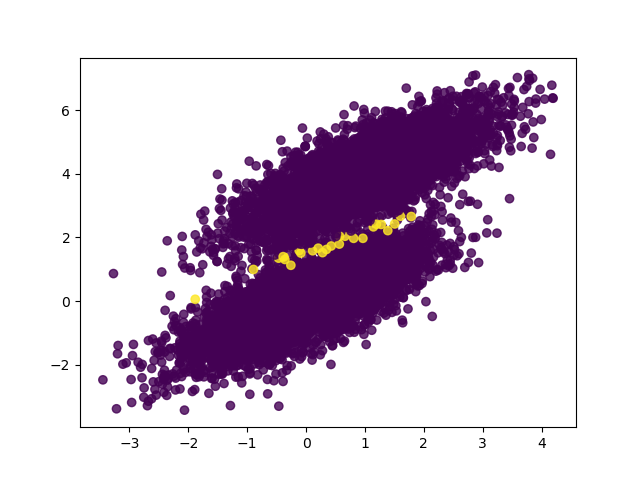

In [37]:
figure()
scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = preds == simulated_labels - 1, alpha = .8)#, s = 30)
show()

# Summary Logistic Regression

* aim: make decisions about (n-dimensional) data containing to one or an other class (2 features and a bias term)
* weight the input data and apply the hypothesis function on the weighted data (sigmoidal function)
* optimize weights (the log-likelyhood by gradient ascent) to match the labeled training data best (= supervised learning)

---

---
# Beyond Binary Classification - Neuronal Networks

The logistic regression using the sigmoid function is useful but limited to rather simple problems with fully **separable data**.
Adding more features would only increase the size of the weigth vector which is fine.
But adding more classes is just not possible.

The way out are networks with a linear combination of nodes performing a single decision - for instance using the sigmoid function, or also popular the **relu** function - that have more than one output node at the end.

By adding a third point cloud to the data above (for instance a not dangerous cancer type that however should be removed) is becomes neccessary to use a (neuronal) network of nodes:

<IPython.core.display.Javascript object>


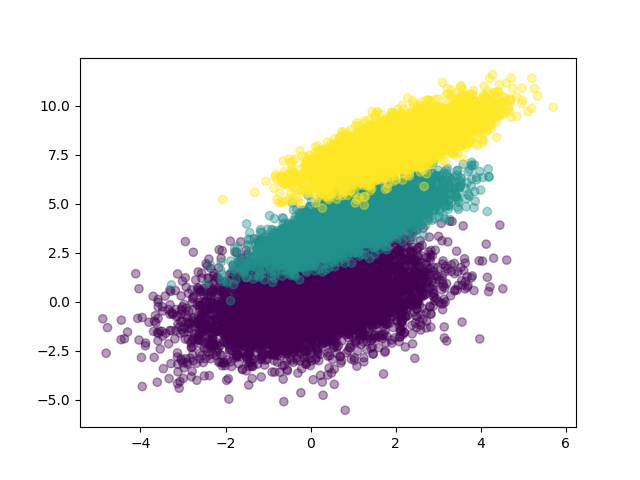

In [39]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((
    np.zeros(num_observations),
    np.ones(num_observations), 
    np.ones(num_observations) + 1
))

figure()
scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
show()

In [ ]:
# import function to get a subset of the simualted data for training and an other subset for testing
from sklearn.model_selection import train_test_split

In [44]:
###### Technical detail  #####
# tensorflow expects one-hot encoded labels ( 1 0 0, 0 1 0, 0 0 1, ...) -> we use this here as well
## init array of labels with [x x x] all zero
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
## first index of labels generated by range function 0,1,2,...; second index is ariginal label (0,1,2)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

# split data set into training and test set
train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    simulated_separableish_features, #input data
    labels_onehot, #input labels
    test_size = .1, #10% of data is going to act as test set
    random_state = 12) # use the same random number seed as before

training_data = train_dataset
training_labels = train_labels
# print("The input data looks like this:\n",training_data[0:3], "\nThe one-hot labels look like this:\n",training_labels[0:3])

## Building a Neural Network from Scratch

For a (feed forward) neural network, we need:

1. A model architecture
2. Arrays of weight vectors
3. Arrays of bias vectors
4. An activation function
5. A function to convert the output to a probability distribution
6. A loss function
7. A way to use the output of the model to tune the model iteratively and improve it (error backpropagation)

## 1. The Model
The model is kept simple:

* the number of input nodes is equal to the number of features: 3 = 2+1 (bias 
* we use one hidden layer with 5 nodes
* the number of output nodes is equal to the number of labels

|input |   | o | o | o |   |
|------|---|---|---|---|---|
|      |---|---|---|---|---|
|hidden| o | o | o | o | o |
|      |---|---|---|---|---|
|output|   | o | o | o |   |

In [45]:
# number of input nodes
num_features = training_data.shape[1]
# number of hidden nodes in out single hidden layer
hidden_nodes = 5
# number of output nodes
num_labels = training_labels.shape[1]

## 2. Arrays of weight vectors

The weight vectors must have the correct dimensions to be simply matrix multiplied with the features/the output of the previous layer.
They can be initialized randomly, but there are more sophisticated methods of course.

In [47]:
# mapping every feature to every hidden node -> dimension first layer weights (num_features x hidden_nodes)
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 

# mapping every hidden node output to an output node -> dimension second layer weigths (hidden_nodes x num_labels)
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

## 3. Arrays of bias terms

The bias term can be added as a separate vector to every feature resulting in a vector of dimension $(1 x \text{ num_features })$.
Hidden layers dont need a bias term as they do not correspond to any number of features or labels anyway.
The output nodes need to get a bias term resulting in dimensionas of $(1 x \text{ num_labels })$.

In [48]:
layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

## 4. Activation function

The activation function is similar to the hypothesis function of the logistic regression.
But, it does not take the decision over the classification. Instead, it decides whether or not the output of a hidden node is passed to the next level of nodes, the output nodes in outr simple model.

The relu function ( [Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) \) is commonly used for this pupose for some good reasons and it looks like this:

<IPython.core.display.Javascript object>


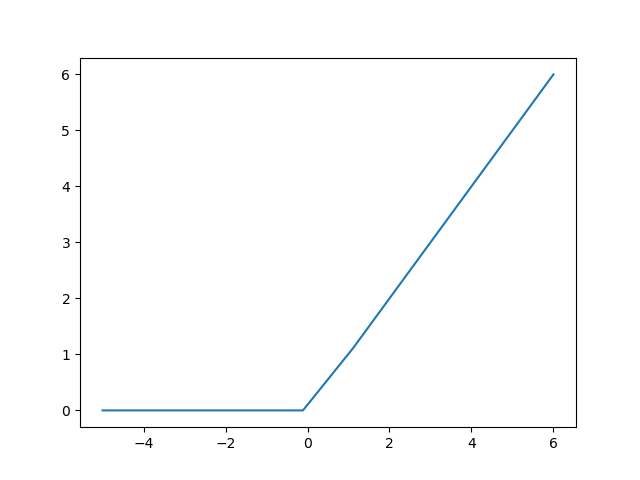

In [55]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

figure()
plot(np.linspace(-5,6,10),relu_activation(np.linspace(-5,6,10)))
show()

## 5. Probability conversion function

To represent the "confidence" of the classification result, the output layer result is postprocesed by the output probability distribution.

For this purpose, the [softmax function](https://en.wikipedia.org/wiki/Softmax_function#Neural_networks) is commonly used

$\sigma (z)_j = \dfrac{\exp{z_j}}{\sum_{i=0}^{K} \exp{z_i} }$ for $j=1,…,K$

In [56]:
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)

## 6. Loss / Cost function

To decide is the weights we have yield good results, the output probability distribution $q(x)$ should be almost equal to the target probability distribution $p(x)$. 
The [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) does exactly this job and is therefore a good candidate for the cost function to be minimized.

$H(p,q)=− \sum_x p(x) \ln{\left[ q(x) \right]}$

Here, the power of one-hot labels comes into play: the target probability of each label is unity.
Thus, we can skip $p(x)$ when $H(p,q)$ is calculated only for the respective label

$H(p,q)=− \sum_x \ln{\left[ q(x) \right]}$

In [57]:
def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    # get an array of the respective output label indizees
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    # filter only the resulting probabilities of the respective labels
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    # calculate H(1,q) componentwise
    log_preds = np.log(predicted_probability)
    
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

Here a technical issue arises:

To avoid overfitting, [regularization](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) is used.
It basically means to almost set small weights to zero to skip unneccessary weights.

In this case we will use L2 regularization.
We add a regularization loss term to the total loss function (that's why **L**) that is a parameter $\lambda$ multiplied by the square (that's why **2**) of the weights.

$ 0.5 \lambda \sum_i \Theta_i^2$

In [58]:
def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    # get the average of both weights (with different dimensionality)
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss

To get the accuracy of the predictions, we assume the label to be exaclty the class with the highest probability and count correct results like before.

In [65]:
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

At this point, we have defined the feed forward model completely and we can calculate for every data point a prediction and the corresponding loss function.
Now, we need to implement the optimization of the parameters.

## 7. Optimising of weights: Backpropagation

This is complicated.
Nevertheless, in principle it mean to take the partial derrivative of a particular weight of the loss function and multiply it with the weighted value of the loss function to get the correction factor of the weight (multiplied by the learning rate of course).
The partial derrivative of the loss function with respect to the weight is calculated applying the chain rule.

But, just see how it looks like and check the comments

In [ ]:
# calculate total error by substracting the target values (=labels) from the prediction and normalize it
output_error_signal = (output_probs - labels_onehot) / output_probs.shape[0]

# calculate the errors in the hidden layer by weighting the error in the output layer with the actual weights
error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
# due to the simplicity of the RELU function, 
#the derivative is eighter 0 if the weighted error is smaller than 0 or 1 otherwise
error_signal_hidden[hidden_layer <= 0] = 0

# using the total errors, the gradient of layer 2 and the corresponding bias can be calculated ... 
gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
# ... and using the hidden layer errors, the gradient of layer 2 and the corresponding bias can be calculated
gradient_layer1_weights = np.dot(training_data.T, error_signal_hidden)
gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

# introduce regularization rate
reg_lambda = .01
# introduce learning rate
learning_rate = .01

# add the regularization weights to the gradients
gradient_layer2_weights += reg_lambda * layer2_weights_array
gradient_layer1_weights += reg_lambda * layer1_weights_array

# perform the weight optimization using the learning rate and the gradients for all weights
layer1_weights_array -= learning_rate * gradient_layer1_weights
layer1_biases_array -= learning_rate * gradient_layer1_bias
layer2_weights_array -= learning_rate * gradient_layer2_weights
layer2_biases_array -= learning_rate * gradient_layer2_bias

This is exactly the same, we did for the logistic regression, but for a large set weights that have differently weighted gradients and that slightly adjusted by the regularization.
The implementation looks so simple, **because of the RELU function and the one-hot encoded labels**.

Now, how do all the 7 parts of the network work togehter in training?

## Training of the neural network

In [62]:
## make sure, the data is correc
#training_data = train_dataset
#training_labels = train_labels

hidden_nodes = 5
num_labels = training_labels.shape[1]
num_features = training_data.shape[1]
learning_rate = .01
reg_lambda = .01

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

# learning loop
for step in range(5001):

    ## forward propagation of the training data
    input_layer = np.dot(training_data, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    ## calculating loss function and regularization
    loss = cross_entropy_softmax_loss_array(output_probs, training_labels)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    ## calculate total error
    output_error_signal = (output_probs - training_labels) / output_probs.shape[0]
    
    ## calculate hidden layer error
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    ## calculate all gradients
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(training_data.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    ## adjust all weights
    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    ## print the progress
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))


Loss at step 0: 2.97038010353472
Loss at step 500: 0.6741319800357115
Loss at step 1000: 0.5042926140598404
Loss at step 1500: 0.41179600916863157
Loss at step 2000: 0.34900224964709387
Loss at step 2500: 0.3060200770944773
Loss at step 3000: 0.27646550016087446
Loss at step 3500: 0.25563870017540147
Loss at step 4000: 0.24049175048229618
Loss at step 4500: 0.22908929922789006
Loss at step 5000: 0.22010325292812327


## Predicting the correct class

To perform a prediction for possibly unknown data, we just perfrom the forward propagation step with the optimized weigths and round the result to the most likely class.

In [66]:
input_layer = np.dot(test_dataset, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, test_labels)))

Test accuracy: 97.13333333333334%


Again, we can plot the results and find the errors to accoure in the overlapping regions which is quite okay

<IPython.core.display.Javascript object>


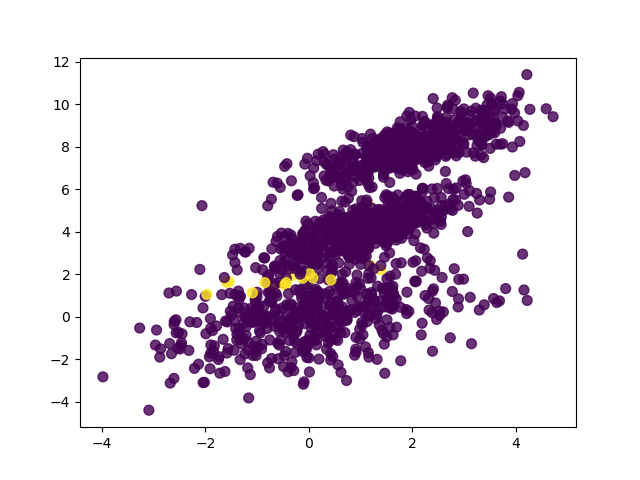

In [67]:
labels_flat = np.argmax(test_labels, axis = 1)
predictions = np.argmax(probs, axis = 1)
figure()
scatter(test_dataset[:, 0], test_dataset[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)
show()

In [ ]:
# Congratulations

You coded a neural network from scratch.

Like with sklearn, there is a popular library for neural networks called tensor flow, that makes things faster, better and requires less coding.
If you manage to install tensor flow on your device, you can try the folloing code and play around with the parameters (learning rate, number of nodes, number of layers,)

In [ ]:
########################################################
#    THIS REQUIRES TENSORFLOW TO BE INSTALLED          #
########################################################

# How does it look like using tensorflow?
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# 
# ########################################################################################
# # again setup the simulated data
# np.random.seed(12)
# num_observations = 5000
# x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
# x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
# x3 = np.random.multivariate_normal([2, 8], [[1, .75],[.75, 1]], num_observations)
# simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
# simulated_labels = np.hstack((
#     np.zeros(num_observations),
#     np.ones(num_observations), 
#     np.ones(num_observations) + 1
# ))
# 
# # tensorflow expects one-hot encoded labels ( 1000, 0100, 0010, ...)
# labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
# labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1
# 
# # split data set into training and test set
# train_dataset, test_dataset, train_labels, test_labels = train_test_split(
#     simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)
# 
# ########################################################################################
# # setup model parameters
# hidden_nodes = 5
# num_labels = train_labels.shape[1]
# batch_size = 100
# num_features = train_dataset.shape[1]
# learning_rate = .01
# 
# # build up the graph = the network
# graph = tf.Graph()
# with graph.as_default():
#     
#     # Data
#     tf_train_dataset = tf.placeholder(tf.float32, shape = [None, num_features])
#     tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels])
#     tf_test_dataset = tf.constant(test_dataset)
#   
#     # Weights and Biases
#     layer1_weights = tf.Variable(tf.truncated_normal([num_features, hidden_nodes]))
#     layer1_biases = tf.Variable(tf.zeros([hidden_nodes]))
#     
#     layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
#     layer2_biases = tf.Variable(tf.zeros([num_labels]))
#     
#     # Three-Layer Network
#     def three_layer_network(data):
#         input_layer = tf.matmul(data, layer1_weights)
#         hidden = tf.nn.relu(input_layer + layer1_biases)
#         output_layer = tf.matmul(hidden, layer2_weights) + layer2_biases
#         return output_layer
#     
#     # Model Scores
#     model_scores = three_layer_network(tf_train_dataset)
#     
#     # Loss
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model_scores, tf_train_labels))
#   
#     # Optimizer.
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#     
#     # Predictions
#     train_prediction = tf.nn.softmax(model_scores)
#     test_prediction = tf.nn.softmax(three_layer_network(tf_test_dataset))
#     
# # define an accuracy function that takes one-hot encoded labels
# def accuracy(predictions, labels):
#     preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
#     correct_predictions = np.sum(preds_correct_boolean)
#     accuracy = 100.0 * correct_predictions / predictions.shape[0]
#     return accuracy
# 
# # last setup - how many steps to iterate:
# num_steps = 10001
# 
# ########################################################################################
# # now run the graph in batches with the training data and the test data 
# with tf.Session(graph=graph) as session:
#     tf.initialize_all_variables().run()
#     for step in range(num_steps):
#         offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#         minibatch_data = train_dataset[offset:(offset + batch_size), :]
#         minibatch_labels = train_labels[offset:(offset + batch_size)]
#         
#         feed_dict = {tf_train_dataset : minibatch_data, tf_train_labels : minibatch_labels}
#         
#         _, l, predictions = session.run(
#             [optimizer, loss, train_prediction], feed_dict = feed_dict
#             )
#         
#         if step % 1000 == 0:
#             print 'Minibatch loss at step {0}: {1}'.format(step, l)
# 
#     print 'Test accuracy: {0}%'.format(accuracy(test_prediction.eval(), test_labels))
    
#################################################################################